<a href="https://colab.research.google.com/github/KangPixel/AIFFEL_quest_cr/blob/master/Exploration/Ex06/Ex06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

In [3]:
# 메모리 삭제
torch.cuda.empty_cache()

In [4]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 363.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.5 MB/s eta 0:00:00


In [5]:
#인체 자세 감지
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

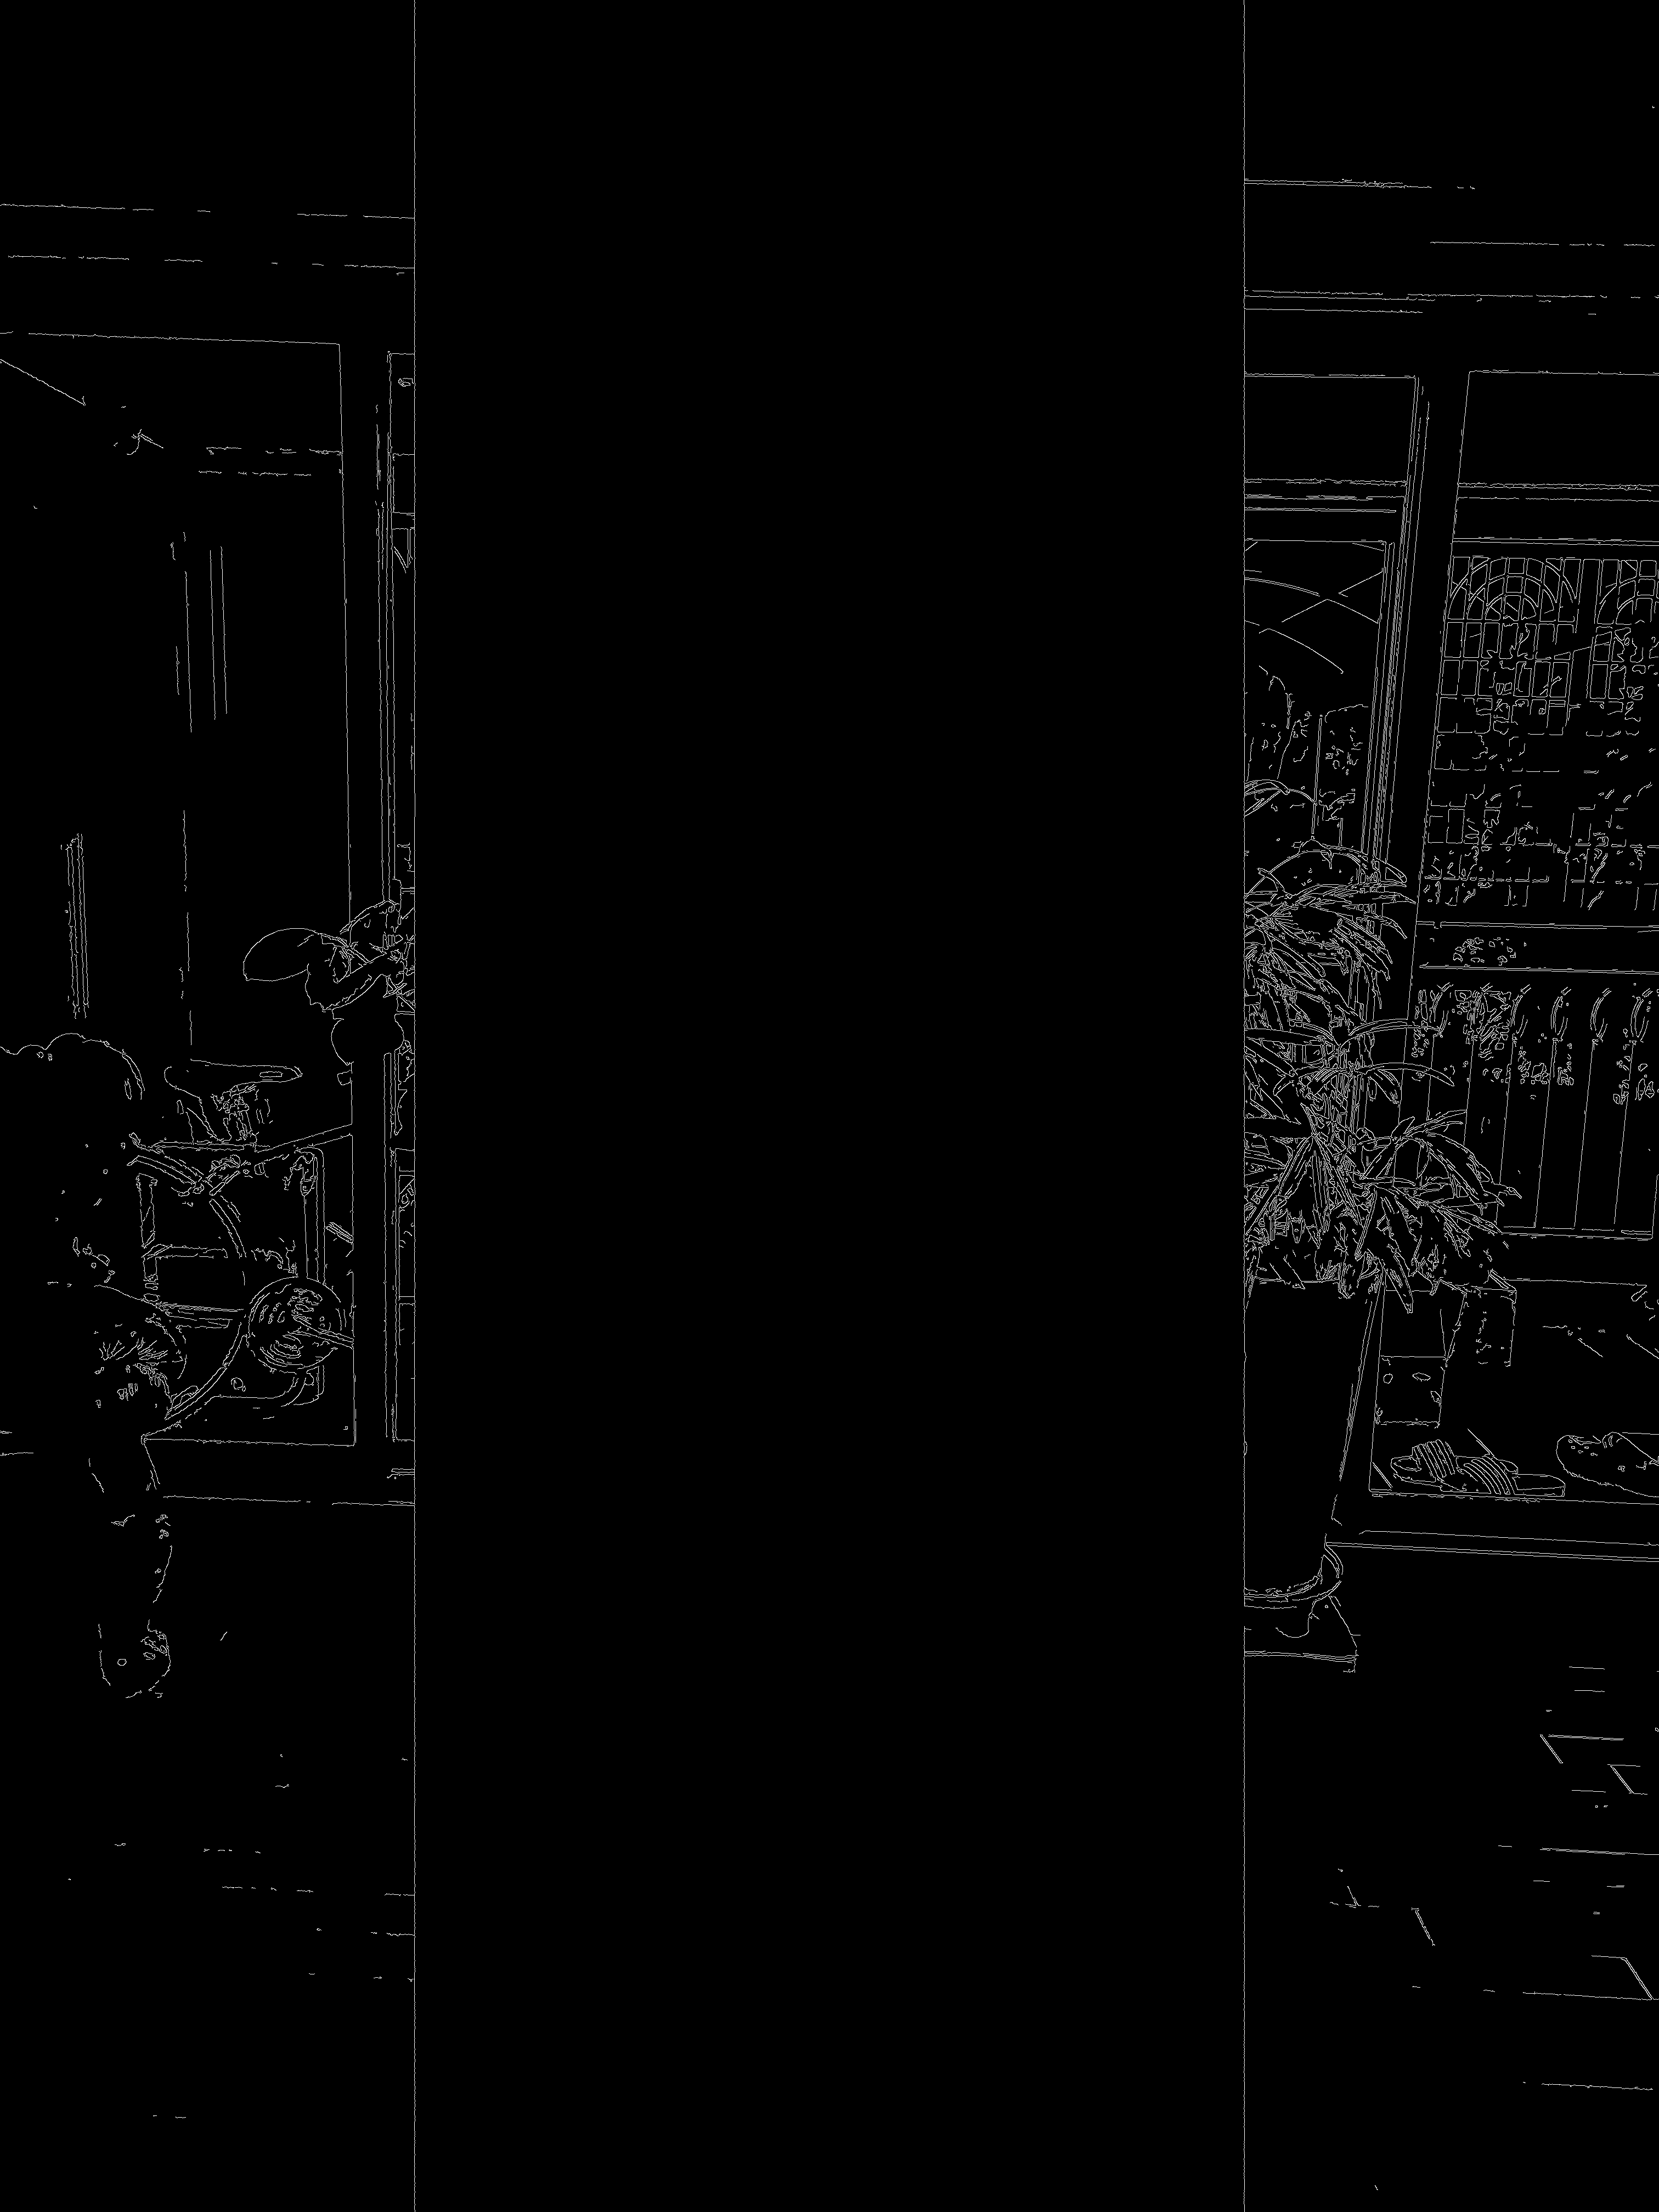

In [8]:
from PIL import Image
import cv2
import numpy as np

# 이미지를 불러옵니다.
canny_image_path = "/content/drive/MyDrive/Colab Notebooks/images/fist.jpg"
canny_image = cv2.imread(canny_image_path)
canny_image = cv2.cvtColor(canny_image, cv2.COLOR_BGR2RGB)

# 이미지를 NumPy 배열로 변환합니다.
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출합니다.
low_threshold = 100
high_threshold = 200
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

# PIL 이미지로 변환합니다.
canny_image = Image.fromarray(canny_image)

# 결과 확인
canny_image

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

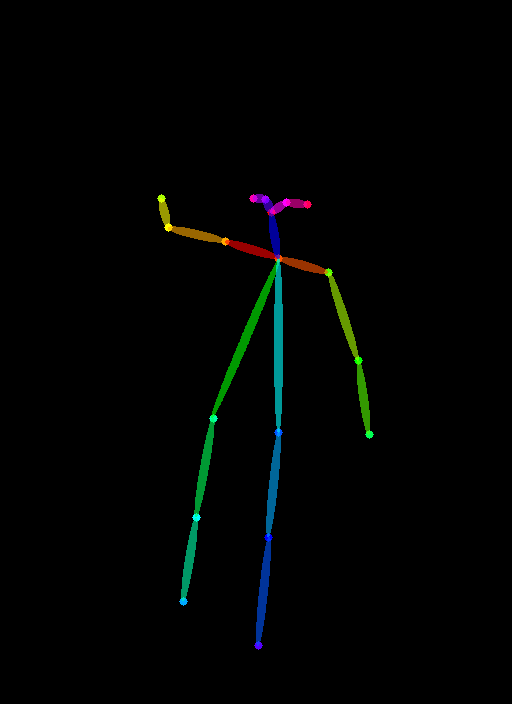

In [9]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다.
openpose_image = "/content/drive/MyDrive/Colab Notebooks/images/fist.jpg"

openpose_image = cv2.imread(openpose_image)
openpose_image = cv2.cvtColor(openpose_image, cv2.COLOR_BGR2RGB)
openpose_image = Image.fromarray(openpose_image)
openpose_image

# OpenposeDetector를 사용하여 인체 자세를 검출합니다.
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)
openpose_image

In [12]:
print("Canny Image Size:", canny_image.size)
print("Openpose Image Size:", openpose_image.size)

Canny Image Size: (3024, 4032)
Openpose Image Size: (512, 704)


In [13]:
# 이미지 크기를 통일합니다.
target_size = (512, 704)
canny_image = canny_image.resize(target_size, Image.BICUBIC)
openpose_image = openpose_image.resize(target_size, Image.BICUBIC)

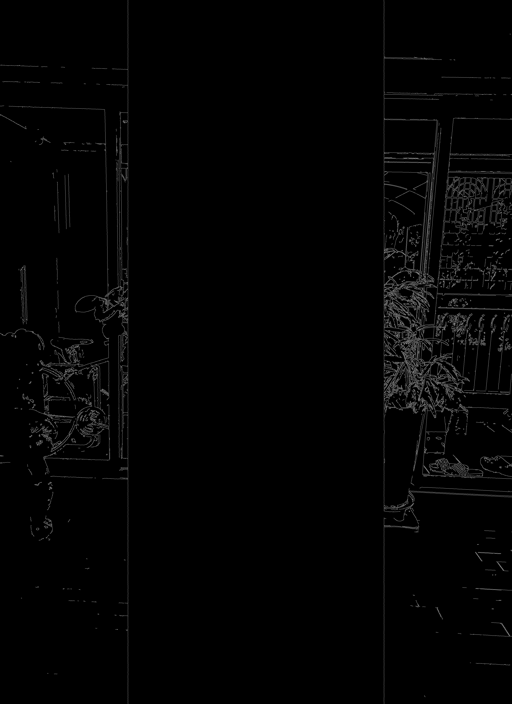

In [19]:
canny_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

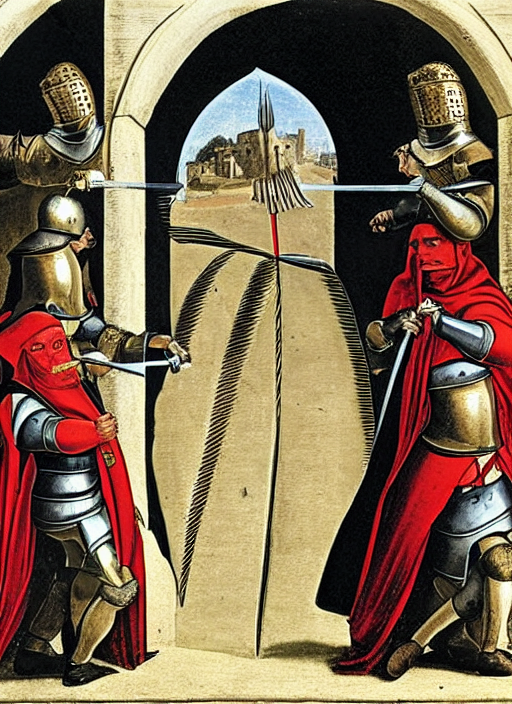

In [26]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
controlnets = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt =  "A pose of a knight fighting an enemy in the Middle Ages"
negative_prompt =  "low quality, blurry, dark, noisy"

# seed를 지정합니다.
generator = torch.manual_seed(0)

images = [openpose_image, canny_image]

# 이미지를 생성합니다.
image =  pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    image=images,
    generator=generator,
    # controlnet_conditioning_scale=[1.5, 0.5]  # 중요도 조정
    ).images[0]

# 생성된 이미지를 저장합니다.
image.save(f"/content/drive/MyDrive/Colab Notebooks/images/multi_controlnet_output.png")


# 생성된 이미지를 출력합니다.
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

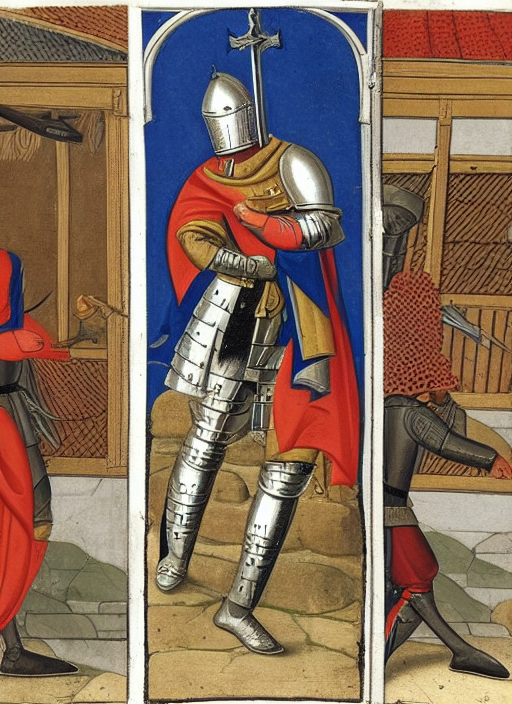

In [25]:
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
controlnets = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
    # ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt =  "A pose of a knight fighting an enemy in the Middle Ages"
negative_prompt =  "low quality, blurry, dark, noisy"

# seed를 지정합니다.
generator = torch.manual_seed(0)

images = [canny_image]

# 이미지를 생성합니다.
image =  pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    image=images,
    generator=generator,
    # controlnet_conditioning_scale=[1.5, 0.5]  # 중요도 조정
    ).images[0]

# 생성된 이미지를 저장합니다.
image.save(f"/content/drive/MyDrive/Colab Notebooks/images/multi_controlnet_output_2.png")


# 생성된 이미지를 출력합니다.
image

In [ ]:
print("생성한 이미지를 올린 곳은 https://github.com/KangPixel/AIFFEL_quest_cr/tree/master/Exploration/Ex06 입니다.")